In [1]:
import numpy as np
import pandas as pd

#import visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mat

In [2]:
df = pd.read_excel("Datasets/Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df1 = df.copy()
df1.Country.nunique() # number of unique countries

38

In [4]:
df1.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [5]:
customer_country=df1[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').sort_values(ascending=False).reset_index()
# 3950 customers from the United Kingdom.

,Country,CustomerID
0,United Kingdom,3950
1,Germany,95
2,France,87
3,Spain,31
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,15
8,Finland,12
9,Austria,11


In [6]:
# Focus on the UK
df1 = df1.loc[df1['Country'] == 'United Kingdom']
# Remove empty CustomerID values
df1 = df1[pd.notnull(df1['CustomerID'])]
# Check if price, quantity > 0
df1.UnitPrice.min()
df1.Quantity.min()
df1 = df1[(df1['Quantity']>0)]

df1.shape
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [7]:
# Check unique value for each column.
def unique_counts(df1):
   for i in df1.columns:
       count = df1[i].nunique()
       print(i, ": ", count)
unique_counts(df1)

InvoiceNo :  16649
StockCode :  3645
Description :  3844
Quantity :  294
InvoiceDate :  15615
UnitPrice :  403
CustomerID :  3921
Country :  1


In [8]:
# Add a feature of TotalPrice
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']

In [9]:
# Find out the first and last order dates in the data.
df1['InvoiceDate'].min()
df1['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [10]:
# Since recency is calculated for a point in time, 
# and the last invoice date is 2011–12–09, 
# we will use 2011–12–10 to calculate recency.

import datetime as dt
NOW = dt.datetime(2011,12,10)
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

In [11]:
# RFM Customer Segmentation
rfmTable = df1.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days, 
    'InvoiceNo': lambda x: len(x), 
    'TotalPrice': lambda x: x.sum()})
rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.columns = ['recency','frequency','monetary']
rfmTable

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34
...,...,...,...
18280.0,277,10,180.60
18281.0,180,7,80.82
18282.0,7,12,178.05


In [12]:
# Split the metrics
quantiles = rfmTable.quantile(q=[0.25,0.75])
quantiles = quantiles.to_dict()

# get rank for each metrics
def rank_r(x, p, t):
    if x <= t[p][0.25]:
        return str(1)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(3)
    
def rank_f(x, p, t):
    if x <= t[p][0.25]:
        return str(3)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(1)
    
def rank_m(x, p, t):
    if x <= t[p][0.25]:
        return str(3)
    elif x <= t[p][0.75]: 
        return str(2)
    else:
        return str(1)

In [13]:
segmented_rfm = rfmTable
segmented_rfm['rank_r'] = segmented_rfm['recency'].apply(rank_r, args=('recency',quantiles))
segmented_rfm['rank_f'] = segmented_rfm['frequency'].apply(rank_f, args=('frequency',quantiles))
segmented_rfm['rank_m'] = segmented_rfm['monetary'].apply(rank_m, args=('monetary',quantiles))
segmented_rfm.head()

,recency,frequency,monetary,rank_r,rank_f,rank_m
CustomerID,,,,,,
12346.0,325,1,77183.60,3,3,1
12747.0,2,103,4196.01,1,1,1
12748.0,0,4596,33719.73,1,1,1
12749.0,3,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [14]:
# Add a new column to combine RFM score: 
# 111 is the highest score as we determined earlier.
segmented_rfm['rfm_score'] = segmented_rfm.rank_r + segmented_rfm.rank_f + segmented_rfm.rank_m
segmented_rfm.head()

,recency,frequency,monetary,rank_r,rank_f,rank_m,rfm_score
CustomerID,,,,,,,
12346.0,325,1,77183.60,3,3,1,331
12747.0,2,103,4196.01,1,1,1,111
12748.0,0,4596,33719.73,1,1,1,111
12749.0,3,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


In [15]:
segmented_rfm.rfm_score.nunique()

25

In [16]:
df2 = segmented_rfm[segmented_rfm['rfm_score']=='111'].sort_values('monetary', ascending=False)
df2.reset_index(inplace=True)

In [17]:
df3 = df2['CustomerID']
df3.to_csv("Datasets/BestCustomer.csv")

In [18]:
def define_rfm_segment(rows):
    if rows['rfm_score'] == '111':
        return 'best_users'
    elif rows['rfm_score'] == '211':
        return 'almost_lost'
    elif rows['rfm_score'] == '311':
        return 'lost_users'
    elif rows['rank_r'] == '3':
        return 'cheap_lost'
    elif rows['rank_f'] == '1':
        return 'loyal_users'
    elif rows['rank_m'] == '1':
        return 'big_spender'
    elif rows['rank_f'] == '3':
        return 'new_customer'
    else:
        return rows['rfm_score']    
    
#Define segment based on RFM score 
segmented_rfm['segment'] = segmented_rfm.apply(define_rfm_segment, axis =1)
segmented_rfm

,recency,frequency,monetary,rank_r,rank_f,rank_m,rfm_score,segment
CustomerID,,,,,,,,
12346.0,325,1,77183.60,3,3,1,331,cheap_lost
12747.0,2,103,4196.01,1,1,1,111,best_users
12748.0,0,4596,33719.73,1,1,1,111,best_users
12749.0,3,199,4090.88,1,1,1,111,best_users
12820.0,3,59,942.34,1,2,2,122,122
...,...,...,...,...,...,...,...,...
18280.0,277,10,180.60,3,3,3,333,cheap_lost
18281.0,180,7,80.82,3,3,3,333,cheap_lost
18282.0,7,12,178.05,1,3,3,133,new_customer


In [19]:
segmented_rfm.segment.unique()

array(['cheap_lost', 'best_users', '122', '222', 'big_spender',
       'almost_lost', 'loyal_users', 'lost_users', '223', 'new_customer',
       '123'], dtype=object)

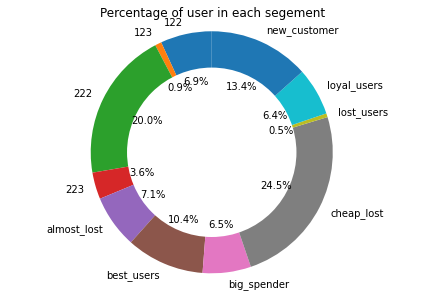

In [20]:
# Visualize the user segments
segmented_rfm.reset_index(inplace=True)
segmented_rfm_count = segmented_rfm.groupby('segment').agg({'CustomerID':['count'],'monetary':['sum']}).reset_index()
segmented_rfm_count.columns = ['segment','user','amount']
segmented_rfm_count[['amount']] = segmented_rfm_count[['amount']]/100
fig1, ax1 = plt.subplots()
ax1.pie(data=segmented_rfm_count, x='user', labels='segment',  autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentage of user in each segement")
plt.show()

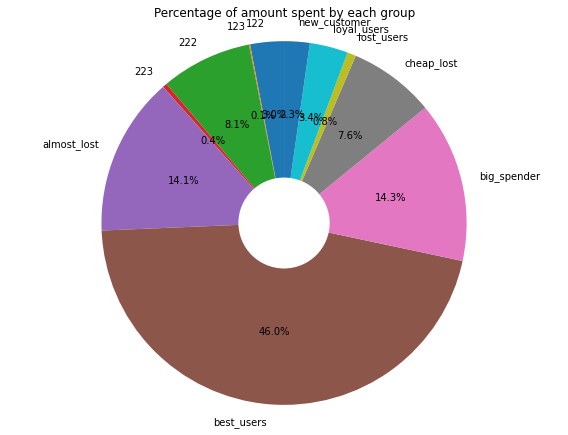

In [21]:
# Visualize the amount spent by user segments
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(data=segmented_rfm_count, x='amount', labels='segment',  autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.25,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentage of amount spent by each group")
plt.show()

In [22]:
# function to label each user as high growth or not
def Label_Segments(rows):
    if rows['segment'] == 'best_users':
        return 1
    elif rows['segment'] == 'big_spender':
        return 1
    else:
        return 0

segmented_rfm['high_growth'] = segmented_rfm.apply(Label_Segments, axis =1)
user_label = segmented_rfm[['CustomerID', 'high_growth']]
user_label

,CustomerID,high_growth
0,12346.0,0
1,12747.0,1
2,12748.0,1
3,12749.0,1
4,12820.0,0
...,...,...
3916,18280.0,0
3917,18281.0,0
3918,18282.0,0
3919,18283.0,1


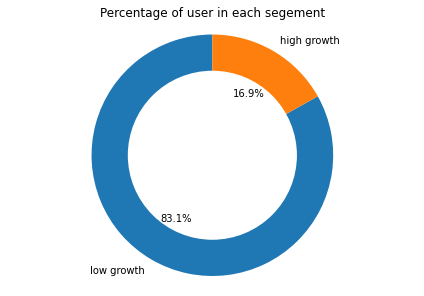

In [23]:
# Visualize High Growth Users
growth_count=segmented_rfm.groupby('high_growth').agg({'CustomerID':['count'],'monetary':['sum']}).reset_index()
growth_count.columns = ['segment','user','amount']
growth_count.loc[growth_count['segment']==0, 'segment'] ='low growth'
growth_count.loc[growth_count['segment']==1, 'segment'] ='high growth'

fig1, ax1 = plt.subplots()
ax1.pie(data=growth_count, x='user', labels='segment',  autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Percentage of user in each segement")
plt.show()

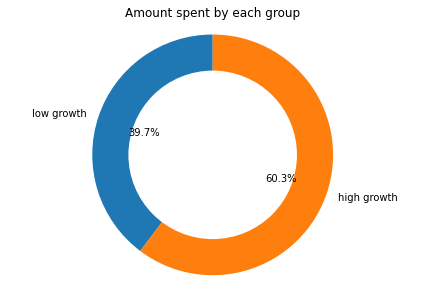

In [24]:
# Amount Spent by High Growth Users
fig1, ax1 = plt.subplots()
ax1.pie(data=growth_count, x='amount', labels='segment',  autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Amount spent by each group")
plt.show()